In [3]:
%load_ext autoreload
%autoreload 3

In [4]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

# Ajuste y selección de distribuciones con Python

> Métodos para encontrar la distribución que mejor se ajusta a los datos.

## Introducción

Identificar el tipo de distribución que tiene a una variable es un paso fundamental en prácticamente todos los estudios que implican datos, desde los contrastes de hipótesis hasta la creación de modelos por aprendizaje estadístico y machine learning.

En Python existen varias librerías que permiten ajustar distribuciones. En este documento se muestran las funcionalidades del módulo scipy.stats, haciendo hincapié en cómo comparar múltiples distribuciones con el objetivo de identificar a cuál de ellas se ajustan mejor los datos.

## Ajuste de una distribución

Ajustar una distribución paramétrica a partir de un conjunto de datos consiste en encontrar el valor de los parámetros con los que, con mayor probabilidad, dicha distribución puede haber generado los datos observados. Por ejemplo, la distribución normal tiene dos parámetros (media y varianza), una vez conocidos estos dos parámetros, se conoce toda la distribución.

Existen varios métodos que permiten encontrar los parámetros óptimos que mejor se ajustan a los datos, uno de los más utilizados, y el que implementa scipy.stats, es el método de [Maximum Likelihood Estimation (MLE)](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (máxima verosimilitud). scipy.stats dispone de más de 90 distribuciones, puede encontrarse un listado de todas ellas en:

- [Distribuciones continuas](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions)

- [Distribuciones continuas multivariante](https://docs.scipy.org/doc/scipy/reference/stats.html#multivariate-distributions)

- [Distribuciones discretas](https://docs.scipy.org/doc/scipy/reference/stats.html#discrete-distributions)

Además de diferenciar entre distribuciones continuas y discretas, es útil poder seleccionarlas por el rango de valores sobre el que está definida cada distribución (dominio). Por ejemplo, si se quiere modelar la velocidad del viento, aunque no se conozca el tipo exacto de distribución, se puede acotar a aquellas cuyo rango de valores está limitado entre $0$ y $+\inf$

In [5]:
from scipy import stats
import pandas as pd

# Distribuciones agrupadas por dominio
# ==============================================================================
distribuciones = [getattr(stats,d) for d in dir(stats) \
                  if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]

distribucion = []     
dominio_1 = []
dominio_2 = []

for dist in distribuciones:
    distribucion.append(dist.name)
    dominio_1.append(dist.a)
    dominio_2.append(dist.b)
    
info_distribuciones = pd.DataFrame({
                        'distribucion': distribucion,
                        'dominio_1': dominio_1,
                        'dominio_2': dominio_2
                      })

info_distribuciones = info_distribuciones \
                      .sort_values(by=['dominio_1', 'dominio_2'])\
                      .reset_index(drop=True)

print("-------------------------------------")
print("Información distribuciones scipy.stat")
print("-------------------------------------")
display(info_distribuciones)

-------------------------------------
Información distribuciones scipy.stat
-------------------------------------


,distribucion,dominio_1,dominio_2
0,levy_l,-inf,0.0
1,weibull_max,-inf,0.0
2,cauchy,-inf,inf
3,crystalball,-inf,inf
4,dgamma,-inf,inf
...,...,...,...
123,pareto,1.0,inf
124,truncpareto,1.0,inf
125,yulesimon,1.0,inf
126,zipf,1.0,inf


## Comparación de ajustes

El método de ajuste por Maximum Likelihood Estimation (MLE) consigue, dada una determinada distribución, encontrar el valor sus parámetros con los que mejor se ajusta a los datos. En la práctica, es frecuente no conocer de antemano qué tipo de distribución siguen los datos. Aunque con la experiencia, el analista suele poder acotar las distribuciones candidatas (distribuciones continuas o discretas, distribuciones solo positivas, etc), es necesaria una forma de cuantificar la bondad de ajuste de cada distribución y, además, poder comparar entre distintas distribuciones candidatas.

### Generalized Akaike information criterion (GAIC)

En distribuciones paramétricas que han sido ajustadas siguiendo una estrategia de Maximum Likelihood Estimation (MLE), una forma de cuantificar la bondad de ajuste del modelo, es decir, lo bien que se ajusta a los datos, es empleando el propio valor de likelihood conseguido en el ajuste. ¿Qué significa esto?

El valor de likelihood devuelto por una distribución para una observación $x_i$ es una medida de la probabilidad con la que esa distribución podría haber generado dicha observación. Para facilitar los cálculos matemáticos, normalmente se utiliza el logaritmo ( log likelihood), pero la interpretación es la misma, a mayor log likelihood mayor probabilidad.

Si se suma el log likelihood de todas las observaciones con las que se ha ajustado la distribución, se dispone de un valor que mide la "compatibilidad" entre la distribución y los datos. Siguiendo esta idea es como se define el término fitted global deviance (GDEV), que no es más que el log likelihood del modelo multiplicado por $-2$

$$ \text{GDEV} = − 2 \log(likelihood)$$

El problema de emplear el GDEV para comparar distribuciones es que no tiene en cuenta los grados de libertad de cada una (su flexibilidad). En términos generales, cuantos más parámetros tenga una distribución, con más facilidad se ajusta a los datos y mayor es su log likelihood. Esto significa que utilizar el GDEV o el log likelihood para comparar distribuciones con distinto número de parámetros no es una estrategia justa, casi siempre ganará la que más parámetros tenga aunque no sea realmente la que mejor describe el comportamiento de los datos.

Una forma de mitigar este problema es mediante el uso del GAIC (generalized Akaike information criterion), que incorpora una penalización $k$ por cada parámetro que tenga la distribución:

$$\text{GAIC} = \text{GDEV} + k \times \text{nº parámetros}=$$

$$= −2 \log(likelihood) + k \times \text{nº parámetros}$$

Dependiendo del grado de penalización, se favorece más o menos la sencillez del modelo. Dos estándares de esta métrica son el AIC (Criterio de información de Akaike) y BIC (Bayesian information criterion) también conocida como SBC. El primero utiliza como valor de penalización $k=2$ y el segundo $k=\log(\text{nº observaciones)}$

$$\text{AIC} = −2 \log(\text{likelihood}) + 2  \times \text{nº parámetros}$$

$$\text{BIC}  = −2 \log(\text{likelihood}) + log (\text{nº observaciones}) \times \text{nº parámetros}$$

En la práctica, AIC suele favorecer distribuciones con un más parámetros (overfitting), mientras BIC/SBC tiende al contrario underfitting. Los autores del paquete del libro Distributions for Modeling Location, Scale, and Shape Using GAMLSS in R recomiendan el uso de valores de $k$ en el rango $2.5 \leq k \leq 4$ o de $k = \sqrt{\log(n)}$ cuando $n \geq 1000$.

Para todas ellas, cuanto menor sea el valor, mejor el ajuste. El cambio en la dirección de selección respecto al log likelihood se debe a que en ambas métricas se multiplica por -2, por lo tanto, si interesan valores elevados de log likelihood, al multiplicar por -2, interesan valores muy negativos.

Es importante tener en cuenta que, ninguna de estas métricas, sirven para cuantificar la calidad del ajuste en un sentido absoluto, sino para comparar la calidad relativa entre distribuciones. Si todas las distribuciones ajustadas son malas, no proporcionan ningún aviso de ello.

## Ejemplo 1

> En este ejemplo se procede a ajustar dos distribuciones, normal y gamma, con el objetivo de modelizar la distribución del precio de venta de diamantes. Además de realizar los ajustes, se representan gráficamente los resultados y se calculan las métricas de bondad de ajuste AIC, BIC y Log-Likelihood con el objetivo de comparar e identificar el mejor que distribución se ajusta mejor.


### Librerías

In [6]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Graficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Ajuste de distribuciones
from scipy import stats
import inspect
from statsmodels.distributions.empirical_distribution import ECDF

# Ignorar warnings
import warnings

warnings.filterwarnings("ignore")

# Configuracion de matplotlib
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16, 9)
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

### Datos

> Para esta demostración se emplean como datos el precio de los diamantes disponible en data set diamonds de la librería `seaborn`, en concreto, la columna price.

In [7]:
# Datos
# ==============================================================================
datos = sns.load_dataset('diamonds')
datos = datos.loc[datos.cut == 'Fair', 'price']

Dos de los primeros pasos a la hora de analizar una variable son: calcular los principales estadísticos descriptivos y representar las distribuciones observadas (empíricas).

Si los datos se almacenan en un `Serie` de `Pandas`, pueden obtenerse los principales estadísticos descriptivos con el método `describe()`.

In [8]:
# Estadísticos descriptivos
# ==============================================================================
datos.describe()

count     1610.000000
mean      4358.757764
std       3560.386612
min        337.000000
25%       2050.250000
50%       3282.000000
75%       5205.500000
max      18574.000000
Name: price, dtype: float64

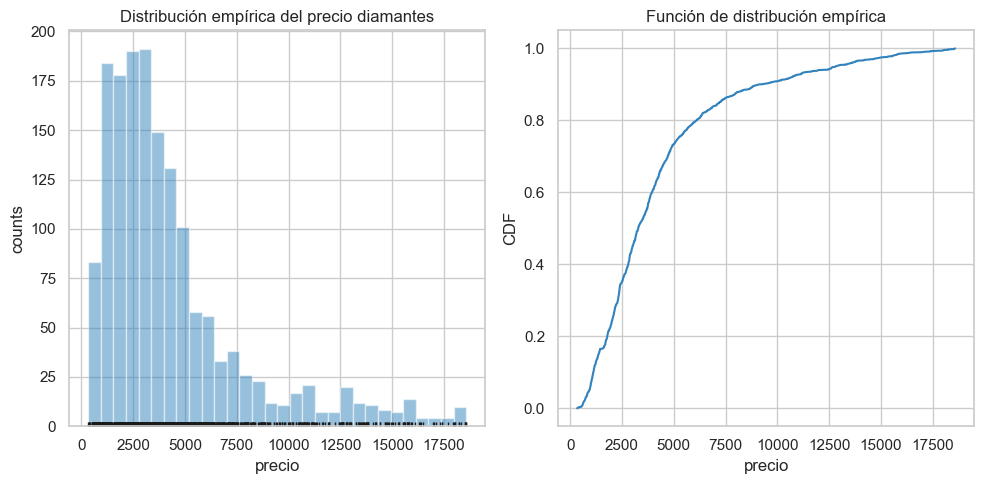

In [9]:
# Gráficos distribución observada (empírica)
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Histograma
axs[0].hist(x=datos, bins=30, color="#3182bd", alpha=0.5)
axs[0].plot(datos, np.full_like(datos, -0.01), '|k', markeredgewidth=1)
axs[0].set_title('Distribución empírica del precio diamantes')
axs[0].set_xlabel('precio')
axs[0].set_ylabel('counts')

# Función de Distribución Acumulada
# ecdf (empirical cumulative distribution function)
ecdf = ECDF(x=datos)
axs[1].plot(ecdf.x, ecdf.y, color="#3182bd")
axs[1].set_title('Función de distribución empírica')
axs[1].set_xlabel('precio')
axs[1].set_ylabel('CDF')

plt.tight_layout()
plt.show()

---------------------
Resultados del ajuste
---------------------
Distribución:   norm

Dominio:        [-inf, inf]

Parámetros:     {'loc': 4358.757763975155, 'scale': 3559.2807303891086}

Log likelihood: -15449.966194325283

AIC:            30903.932388650566

BIC:            30914.700367566522



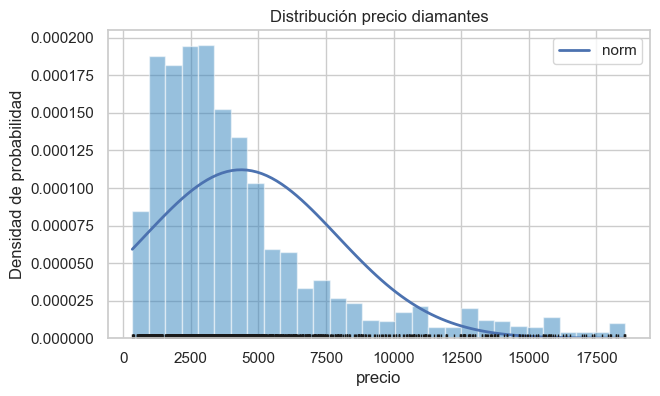

In [10]:
# Ajuste distribución normal
#===============================================================================
# 1) Se define el tipo de distribución
distribucion = stats.norm

# 2) Con el método fit() se obtienen los parámetros
parametros = distribucion.fit(data=datos)

# 3) Se crea un diccionario que incluya el nombre de cada parámetro
nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                     if not p=='x'] + ["loc","scale"]
parametros_dict = dict(zip(nombre_parametros, parametros))

# 3) Se calcula el log likelihood
log_likelihood = distribucion.logpdf(datos.to_numpy(), *parametros).sum()

# 4) Se calcula el AIC y el BIC
aic = -2 * log_likelihood + 2 * len(parametros)
bic = -2 * log_likelihood + np.log(datos.shape[0]) * len(parametros)

# 5) Gráfico
x_hat = np.linspace(min(datos), max(datos), num=100)
y_hat = distribucion.pdf(x_hat, *parametros)
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
ax.hist(x=datos, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(datos, np.full_like(datos, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución precio diamantes')
ax.set_xlabel('precio')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

#6) Información del ajuste
print('---------------------')
print('Resultados del ajuste')
print('---------------------')
print(f"Distribución:   {distribucion.name}\n")
print(f"Dominio:        {[distribucion.a, distribucion.b]}\n")
print(f"Parámetros:     {parametros_dict}\n")
print(f"Log likelihood: {log_likelihood}\n")
print(f"AIC:            {aic}\n")
print(f"BIC:            {bic}\n")

Se repite el proceso, pero esta vez con la distribución gamma.

---------------------
Resultados del ajuste
---------------------
Distribución:   gamma

Dominio:        [0.0, inf]

Parámetros:     {'a': 14.399103124683087, 'loc': -6244.786483560789, 'scale': 726.3476320693849}

Log likelihood: -15235.639828174484

AIC:            30477.27965634897

BIC:            30493.431624722904



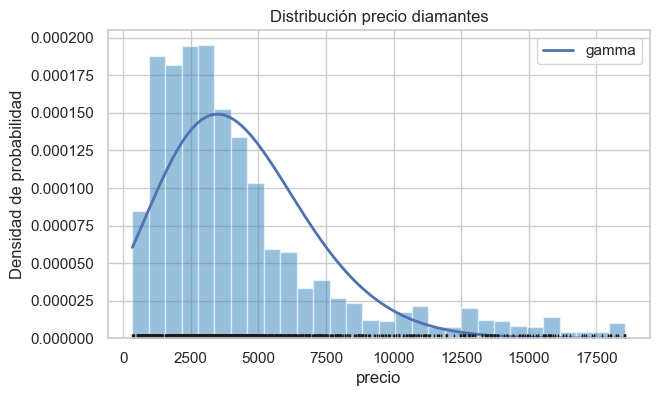

In [11]:
# Ajuste distribución normal
#===============================================================================
# 1) Se define el tipo de distribución
distribucion = stats.gamma

# 2) Con el método fit() se obtienen los parámetros
parametros = distribucion.fit(data=datos)

# 3) Se crea un diccionario que incluya el nombre de cada parámetro
nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                     if not p=='x'] + ["loc","scale"]
parametros_dict = dict(zip(nombre_parametros, parametros))

# 3) Se calcula el log likelihood
log_likelihood = distribucion.logpdf(datos.to_numpy(), *parametros).sum()

# 4) Se calcula el AIC y el BIC
aic = -2 * log_likelihood + 2 * len(parametros)
bic = -2 * log_likelihood + np.log(datos.shape[0]) * len(parametros)

# 5) Gráfico
x_hat = np.linspace(min(datos), max(datos), num=100)
y_hat = distribucion.pdf(x_hat, *parametros)
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
ax.hist(x=datos, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(datos, np.full_like(datos, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución precio diamantes')
ax.set_xlabel('precio')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

#6) Información del ajuste
print('---------------------')
print('Resultados del ajuste')
print('---------------------')
print(f"Distribución:   {distribucion.name}\n")
print(f"Dominio:        {[distribucion.a, distribucion.b]}\n")
print(f"Parámetros:     {parametros_dict}\n")
print(f"Log likelihood: {log_likelihood}\n")
print(f"AIC:            {aic}\n")
print(f"BIC:            {bic}\n")

Tanto la métrica AIC como la BIC coinciden en que la distribución gamma se ajusta mejor a los datos (valores de AIC y BIC más bajos). Esto se puede corroborar fácilmente con la inspección gráfica de los resultados.

En este caso, dado que los valores de precio solo pueden ser positivos y se tienen una notable cola derecha, la distribución gamma era una candidata mucho mejor que la normal. Sin embargo, hay otras posibles distribuciones, algunas de las cuales podrían ser mejores. En el siguiente ejemplo, se muestra cómo automatizar la búsqueda.

## Ajustar y comparar múltiples distribuciones

En el siguiente ejemplo se muestra cómo automatizar el ajuste y comparación de las múltiples distribuciones disponibles es scipy.stats. El código ha de permitir:

- Ajustar todas las distribuciones disponibles en scipy.stats.

- Poder preseleccionar un subconjunto de distribuciones candidatas en función de su dominio.

- Mostrar los parámetros de cada ajuste.

- Calcular los valores AIC y BIC para poder seleccionar la distribución con mejor ajuste.

- Representación gráfica de los resultados.


### Código

Funciones empleadas para comparar múltiples distribuciones.

In [12]:
from scipy import stats
import pandas as pd
import numpy as np
import tqdm
import inspect
import warnings
warnings.filterwarnings('ignore')

def seleccionar_distribuciones(familia='realall', verbose=True):
    '''
    Esta función selecciona un subconjunto de las distribuciones disponibles
    en scipy.stats
    
    Parameters
    ----------
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas
        
    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).
        
    Returns
    -------
    distribuciones: list
        listado con las distribuciones (los objetos) seleccionados.
        
    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.
        
    Notes
    -----
        Las distribuciones levy_stable y vonmises han sido excluidas por el momento.

    '''
    
    distribuciones = [getattr(stats,d) for d in dir(stats) \
                     if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
    
    exclusiones = ['levy_stable', 'vonmises']
    distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
            
    dominios = {
        'realall' : [-np.inf, np.inf],
        'realline': [np.inf,np.inf],
        'realplus': [0, np.inf],
        'real0to1': [0, 1], 
        'discreta': [None, None],
    }

    distribucion = []
    tipo = []
    dominio_inf = []
    dominio_sup = []

    for dist in distribuciones:
        distribucion.append(dist.name)
        tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
        dominio_inf.append(dist.a)
        dominio_sup.append(dist.b)
    
    info_distribuciones = pd.DataFrame({
                            'distribucion': distribucion,
                            'tipo': tipo,
                            'dominio_inf': dominio_inf,
                            'dominio_sup': dominio_sup
                          })

    info_distribuciones = info_distribuciones \
                          .sort_values(by=['dominio_inf', 'dominio_sup'])\
                          .reset_index(drop=True)
    
    if familia in ['realall', 'realline', 'realplus', 'real0to1']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
        condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                    (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
        info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
        
    if familia in ['discreta']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
        
    seleccion = [dist for dist in distribuciones \
                 if dist.name in info_distribuciones['distribucion'].values]
    
    
    if verbose:
        print("---------------------------------------------------")
        print("       Distribuciones seleccionadas                ")
        print("---------------------------------------------------")
        with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
            print(info_distribuciones)
    
    return seleccion


def comparar_distribuciones(x, familia='realall', ordenar='aic', verbose=True):
    '''
    Esta función selecciona y ajusta un subconjunto de las distribuciones 
    disponibles en scipy.stats. Para cada distribución calcula los valores de
    Log Likelihood, AIC y BIC.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas
    
    ordenar : {'aic', 'bic'}
        criterio de ordenación de mejor a peor ajuste.
    
    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).
        
    Returns
    -------
    resultados: data.frame
        distribucion: nombre de la distribución.
        log_likelihood: logaritmo del likelihood del ajuste.
        aic: métrica AIC.
        bic: métrica BIC.
        n_parametros: número de parámetros de la distribución de la distribución.
        parametros: parámetros del tras el ajuste
        
    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.
        
    Notes
    -----

    '''
    
    distribuciones = seleccionar_distribuciones(familia=familia, verbose=verbose)
    distribucion_ = []
    log_likelihood_= []
    aic_ = []
    bic_ = []
    n_parametros_ = []
    parametros_ = []
    
    for i, distribucion in enumerate(distribuciones):
        
        print(f"{i+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
        
        try:
            parametros = distribucion.fit(data=x)
            nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                 if not p=='x'] + ["loc","scale"]
            parametros_dict = dict(zip(nombre_parametros, parametros))
            log_likelihood = distribucion.logpdf(x, *parametros).sum()
            aic = -2 * log_likelihood + 2 * len(parametros)
            bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
            
            distribucion_.append(distribucion.name)
            log_likelihood_.append(log_likelihood)
            aic_.append(aic)
            bic_.append(bic)
            n_parametros_.append(len(parametros))
            parametros_.append(parametros_dict)
            
            resultados = pd.DataFrame({
                            'distribucion': distribucion_,
                            'log_likelihood': log_likelihood_,
                            'aic': aic_,
                            'bic': bic_,
                            'n_parametros': n_parametros_,
                            'parametros': parametros_,
                
                         })
            
            resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)
            
        except Exception as e:
            print(f"Error al tratar de ajustar la distribución {distribucion.name}")
            print(e)
            print("")
            
    return resultados

### Datos

De nuevo se emplean como datos el precio de los diamantes disponible en data set diamonds de la librería `seaborn`, en concreto, la columna _price_.

In [13]:
# Datos
# ==============================================================================
datos = sns.load_dataset('diamonds')
datos = datos.loc[datos.cut == 'Fair', 'price']

### Ajuste de distribuciones

In [14]:
# Ajuste y comparación de distribuciones
# ==============================================================================
resultados = comparar_distribuciones(
                x=datos.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados

1/33 Ajustando distribución: cauchy
2/33 Ajustando distribución: crystalball
3/33 Ajustando distribución: dgamma
4/33 Ajustando distribución: dweibull
5/33 Ajustando distribución: exponnorm
6/33 Ajustando distribución: genextreme
7/33 Ajustando distribución: genhyperbolic
8/33 Ajustando distribución: genlogistic
9/33 Ajustando distribución: gennorm
10/33 Ajustando distribución: gumbel_l
11/33 Ajustando distribución: gumbel_r
12/33 Ajustando distribución: hypsecant
13/33 Ajustando distribución: jf_skew_t
14/33 Ajustando distribución: johnsonsu
15/33 Ajustando distribución: kappa4
16/33 Ajustando distribución: laplace
17/33 Ajustando distribución: laplace_asymmetric
18/33 Ajustando distribución: loggamma
19/33 Ajustando distribución: logistic
20/33 Ajustando distribución: loguniform
21/33 Ajustando distribución: moyal
22/33 Ajustando distribución: nct
23/33 Ajustando distribución: norm
24/33 Ajustando distribución: norminvgauss
25/33 Ajustando distribución: pearson3
26/33 Ajustando distr

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,norminvgauss,-14883.074787,29774.149573,29795.685531,4,"{'a': 53.047412557163966, 'b': 53.025400276075..."
1,genhyperbolic,-14882.515660,29775.031320,29801.951268,5,"{'p': 0.06748200212521904, 'a': 19.46831101851..."
2,johnsonsu,-14885.659055,29779.318110,29800.854067,4,"{'a': -6.066487528038792, 'b': 1.2881784614811..."
3,exponnorm,-14893.092541,29792.185082,29808.337051,3,"{'K': 15.412138315762803, 'loc': 743.857937999..."
4,laplace_asymmetric,-14899.357246,29804.714492,29820.866461,3,"{'kappa': 0.2467457869725307, 'loc': 956.00000..."
5,pearson3,-14901.569768,29809.139537,29825.291505,3,"{'skew': 1.6311412759431207, 'loc': 4358.75780..."
6,genextreme,-14903.676157,29813.352313,29829.504282,3,"{'c': -0.3524573977513747, 'loc': 2547.4073584..."
7,jf_skew_t,-14921.310844,29850.621687,29872.157645,4,"{'a': 9.053572595073181, 'b': 1.07919613250880..."
8,nct,-14931.974511,29871.949021,29893.484979,4,"{'df': 2.090423595048227, 'nc': 2.592582858699..."
9,moyal,-14963.934208,29931.868417,29942.636396,2,"{'loc': 2529.6661504971357, 'scale': 1307.9215..."


### Gráficos 

In [20]:
def plot_distribucion(x, nombre_distribucion, ax=None):
    '''
    Esta función superpone la curva de densidad de una distribución con el
    histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : str
        nombre de una de las distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''

    distribucion = getattr(stats, nombre_distribucion)

    parametros = distribucion.fit(data=x)

    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                         if not p=='x'] + ["loc","scale"]
    parametros_dict = dict(zip(nombre_parametros, parametros))

    log_likelihood = distribucion.logpdf(x, *parametros).sum()

    aic = -2 * log_likelihood + 2 * len(parametros)
    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

    x_hat = np.linspace(min(x), max(x), num=100)
    y_hat = distribucion.pdf(x_hat, *parametros)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5);
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribución')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

    print('---------------------')
    print('Resultados del ajuste')
    print('---------------------')
    print(f"Distribución:   {distribucion.name}")
    print(f"Dominio:        {[distribucion.a, distribucion.b]}")
    print(f"Parámetros:     {parametros_dict}")
    print(f"Log likelihood: {log_likelihood}")
    print(f"AIC:            {aic}")
    print(f"BIC:            {bic}")
    
    return ax


def plot_multiple_distribuciones(x, nombre_distribuciones, ax=None):
    '''
    Esta función superpone las curvas de densidad de varias distribuciones
    con el histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : list
        lista con nombres de distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribuciones')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')
    
    for nombre in nombre_distribuciones:
        
        distribucion = getattr(stats, nombre)

        parametros = distribucion.fit(data=x)

        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                             if not p=='x'] + ["loc","scale"]
        parametros_dict = dict(zip(nombre_parametros, parametros))

        log_likelihood = distribucion.logpdf(x, *parametros).sum()

        aic = -2 * log_likelihood + 2 * len(parametros)
        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

        x_hat = np.linspace(min(x), max(x), num=100)
        y_hat = distribucion.pdf(x_hat, *parametros)
        ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    
    ax.legend()    
    return ax

Se muestra la mejor distribución acorde al criterio AIC.

---------------------
Resultados del ajuste
---------------------
Distribución:   norminvgauss
Dominio:        [-inf, inf]
Parámetros:     {'a': 53.047412557163966, 'b': 53.02540027607523, 'loc': -184.73331867479027, 'scale': 130.96016945949566}
Log likelihood: -14883.074786749965
AIC:            29774.14957349993
BIC:            29795.685531331845


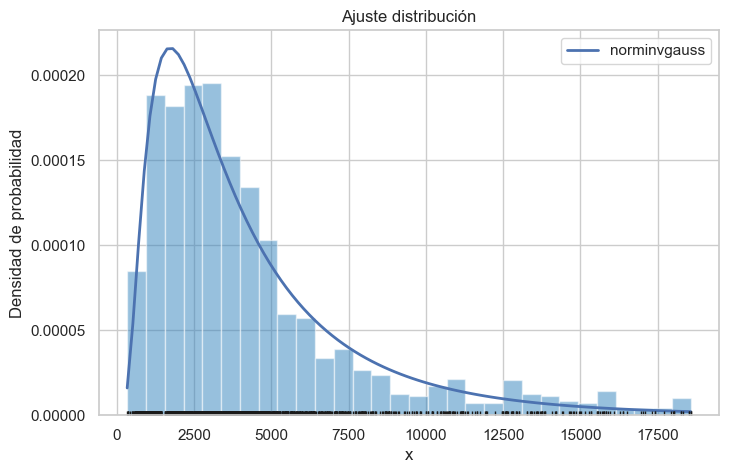

In [21]:
fig, ax = plt.subplots(figsize=(8,5))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados['distribucion'][0],
    ax=ax
)
plt.show()

Las curvas de densidad de probabilidad para las top 5 distribuciones.

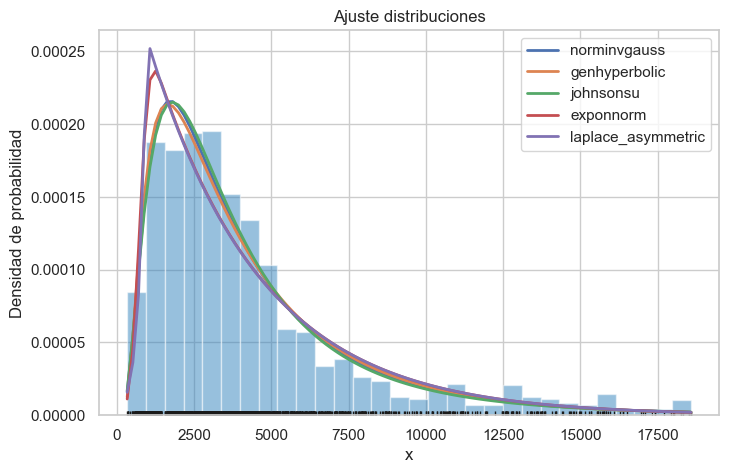

In [22]:
fig, ax = plt.subplots(figsize=(8,5))

plot_multiple_distribuciones(
    x=datos.to_numpy(),
    nombre_distribuciones=resultados['distribucion'][:5],
    ax=ax
)
plt.show()

### Resultados

Acorde al criterio AIC, las dos distribuciones que mejor se adaptan a los datos son: **johnsonsu** y **norminvgauss**.

## Función de densidad, cuantil y muestreo

Todas las funciones implementadas en **scipy.stats** disponen de los métodos `pdf()`, `logpdf()`, `cdf()`, `ppf()` y `rvs()` con los que calcular la densidad, logaritmo de densidad, probabilidad acumulada, cuantiles, y muestreo de nuevos valores. Por ejemplo, se pueden simular 5 nuevos valores de diamantes acorde a la distribución johnsonsu.

In [23]:
# Definición de la distribución
distribucion = stats.johnsonsu

# Ajuste para obtener el valor de los parámetros
parametros   = distribucion.fit(datos.to_numpy())

# Muestreo aleatorio
distribucion.rvs(*parametros, size=5)

array([2298.64067547, 1329.27899072, 6082.70924755, 1984.19254877,
       1318.04662116])